# Summary Table & Finding Codes EDA

## Postgres Connections and Functions

In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import psycopg2
import seaborn as sns
import yaml

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read in config file
with open("../conf/local/db.yaml") as f:
    conf=yaml.safe_load(f)

In [3]:
# set up sqlalchemy engine
host = conf['host']
DB = conf['DB']
user = conf['user']
pw = conf['pw']

connection_string = "postgresql://{}:{}@{}/{}".format(user, pw, host, DB)
conn = sqlalchemy.create_engine(connection_string)

In [4]:
# Get Summary Datatable
query = """
select * 
from DM_Spain_VIEW_study_summary;
"""

sum_table = pd.read_sql(query, conn)
sum_table.head()

,row_id,studyidk,age,gender,patientweight,patientheight,findingcode,findingcodetext,conclusion,reasonforstudy,studylocation,modality,equipment
0,1,118640,77,M,77,162,"LV-0062, LV-0067, LV-0078, LV-0088, RV-0028, R...",Ventrículo izquierdo de dimensiones normales. ...,RS. Buena calidad. ....- VI de tamańo y FEVI n...,SVAo. BAV 2ş,,US,EPIQ7-1
1,2,115777,82,F,45,157,"LV-0063, LV-0069, LV-0078, LV-0086, LV-0087, L...",Cavidad del ventrículo izquierdo reducida. Com...,Estudio de buena calidad. Realizado en RS a 70...,Angina inestable,,US,ECOEPIQ2
2,3,49414,67,M,69,168,"LV-0077, MV-0108, AV-0087",La fracción de eyección del ventrículo izquier...,Seguimiento de P. con C. valvular e Isquemica....,Seguimiento de P. con C. valvular e Isquemica,,"SR, US",ECOIE33
3,4,79460,70,M,68,168,"LV-0078, LV-0145, MV-0056, MV-0099, MV-0108, T...",La función sistólica ventricular izquierda es ...,Seguimiento de P. con C. isquemica cronica (...,Seguimiento de P. con C. isquemica cronica +...,,"SR, US",AFFINITI_1
4,5,118806,72,M,63,167,"LV-0062, LV-0067, RV-0028, RV-0033, RV-0036, L...",Ventrículo izquierdo de dimensiones normales. ...,Estudio realizado en FA 80-90 . Mala ventana ...,,,"SR, US",AFFINITI_2


## Table Cleanup

In [5]:
sum_table_clean = sum_table.copy()

## Number of records in the database

In [6]:
[number_of_rows, number_of_columns] = sum_table_clean.shape
print("number of rows")
print(number_of_rows)
print("number of columns")
print(number_of_columns)

number of rows
25064
number of columns
13


### Blank fields in Database

In [7]:
sum_table_clean.isnull().sum()

row_id             0
studyidk           0
age                0
gender             0
patientweight      0
patientheight      0
findingcode        0
findingcodetext    0
conclusion         0
reasonforstudy     0
studylocation      0
modality           0
equipment          0
dtype: int64

## Gender

USAL has confirmed:
- "O" stands for "Other"
- "U" stands for "Unknown"
- All blanks can be changed to "U" for unknown 

In [8]:
sum_table_clean['gender'].value_counts()

M    12438
F    10120
      1976
O      508
U       22
Name: gender, dtype: int64

In [9]:
sum_table_clean['gender'] = sum_table_clean['gender'].replace('', 'U')
sum_table_clean['gender'].value_counts()

M    12438
F    10120
U     1998
O      508
Name: gender, dtype: int64

## Age

In [10]:
print('Number of cells in the age column that are '' (blank)')
print(sum_table_clean['age'][sum_table_clean['age']==''].count())

print('Number of cells in the age column that are np.nan')
print(sum_table_clean['age'][sum_table_clean['age']==np.nan].count())


Number of cells in the age column that are  (blank)
743
Number of cells in the age column that are np.nan
0


In [11]:
# Clean up cells above by replacing them with 1
sum_table_clean['age'] = sum_table_clean['age'].replace('',1)
#sum_table_clean['age'] = sum_table_clean['age'].replace(np.nan, 1)
sum_table_clean['age'] = sum_table_clean['age'].astype(int)

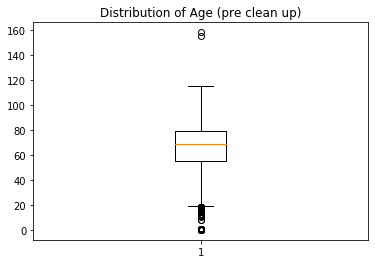

In [12]:
results = plt.boxplot(sum_table_clean['age'])
plt.title('Distribution of Age (pre clean up)')
plt.show()

In [13]:
#get_outlier_thresholds(results) Yoni


In [14]:
print('Highest 10 Ages in dataframe')
print(sum_table_clean['age'].nlargest(10))
print('Lowest 10 Ages in dataframe')
print(sum_table_clean['age'].nsmallest(10))

Highest 10 Ages in dataframe
18739    158
8055     155
12146    115
12151    102
7725     100
10488    100
11956    100
15745    100
20225    100
14613     99
Name: age, dtype: int64
Lowest 10 Ages in dataframe
9677     0
22075    0
22568    0
23898    0
24299    0
24479    0
24525    0
24727    0
88       1
194      1
Name: age, dtype: int64


In [15]:
# where age is more than 115, update value to '1'
sum_table_clean['age'] = sum_table_clean['age'].apply(lambda x: x if x < 115 else 1)


In [16]:
print('Ages in database between 1 and 20 (age & count)')
print(sum_table_clean['age'][(sum_table_clean['age'] > 1) & (sum_table_clean['age'] < 20)].value_counts())
print('Sum of above')
print(sum_table_clean['age'][(sum_table_clean['age'] > 1) & (sum_table_clean['age'] < 20)].count())

Ages in database between 1 and 20 (age & count)
17    55
19    53
18    52
16    43
15    33
14    17
13     6
11     2
8      2
12     1
10     1
Name: age, dtype: int64
Sum of above
265


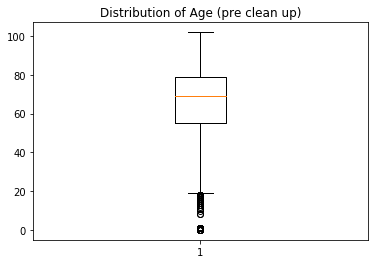

In [17]:
results = plt.boxplot(sum_table_clean['age'])
plt.title('Distribution of Age (pre clean up)')
plt.show()

count    25064.000000
mean        64.284631
std         19.804696
min          0.000000
25%         55.000000
50%         69.000000
75%         79.000000
max        102.000000
Name: age, dtype: float64


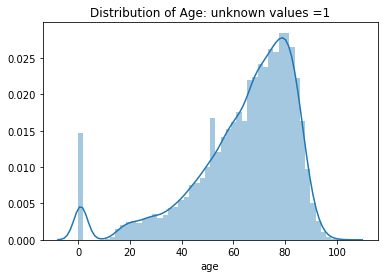

In [18]:
print(sum_table_clean['age'].describe())
#sum_table_clean['age'].hist()
sns.distplot(sum_table_clean['age'])
plt.title('Distribution of Age: unknown values =1')
plt.show()

### Weight

In [19]:
print('Number of cells in the weight column that are '' (blank)')
print(sum_table_clean['patientweight'][sum_table_clean['patientweight']==''].count())

print('Number of cells in the weigh column that are np.nan')
print(sum_table_clean['patientweight'][sum_table_clean['patientweight']==np.nan].count())
print(sum_table_clean['patientweight'].isna().sum())

Number of cells in the weight column that are  (blank)
2582
Number of cells in the weigh column that are np.nan
0
0


In [20]:
# Where value is blank, update value to '1'
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].replace('',1)
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].replace(np.nan, 1)

In [21]:
print('Number of cells in the weight column that contain comma')
print(sum_table_clean['patientweight'][sum_table_clean['patientweight'].str.contains(',', na=False)].count())

Number of cells in the weight column that contain comma
133


In [22]:
#Change commas to decimal points
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].str.replace(',','.')
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].astype(float)
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].fillna(1)
print(sum_table_clean['patientweight'].dtype)

float64


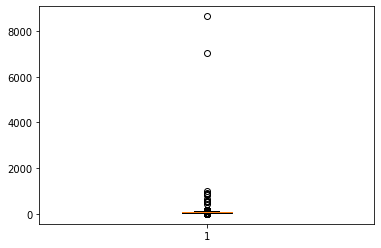

In [23]:
plt.boxplot(sum_table_clean['patientweight'])
plt.show()

Two clear outliers have been replaced with 1


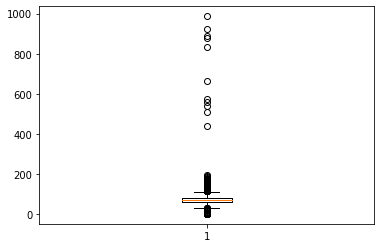

In [24]:
print("Two clear outliers have been replaced with 1")
# where weigh is more than 2000, update value to '1'
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].apply(lambda x: x if x < 2000 else 1)
plt.boxplot(sum_table_clean['patientweight'])
plt.show()

In [25]:
print('Number of studies above 200kg (to be corrected)')
print(sum_table_clean['patientweight'][sum_table_clean['patientweight'] > 200].count())
print('Number of studies below 25kg (to be corrected)')
print(sum_table_clean['patientweight'][(sum_table_clean['patientweight'] > 1) 
                                       & (sum_table_clean['patientweight'] < 25)].count())

Number of studies above 200kg (to be corrected)
11
Number of studies below 25kg (to be corrected)
19


0utliers above 200kg have been replaced with 1


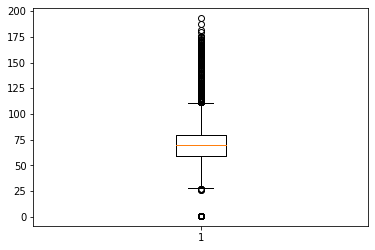

In [26]:
print("0utliers above 200kg have been replaced with 1")
# where weigh is more than 200, update value to '1'
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].apply(lambda x: x if x < 200 else 1)
sum_table_clean['patientweight'] = sum_table_clean['patientweight'].apply(lambda x: x if x > 25 else 1)
plt.boxplot(sum_table_clean['patientweight'])
plt.show()

count    25064.000000
mean        65.147603
std         26.285559
min          1.000000
25%         59.000000
50%         70.000000
75%         80.000000
max        193.000000
Name: patientweight, dtype: float64


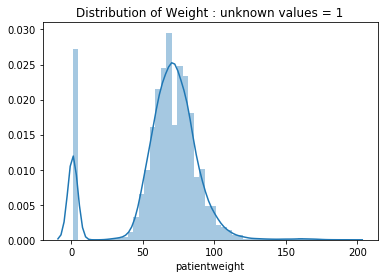

In [27]:
print(sum_table_clean['patientweight'].describe())
#sum_table_clean['patientweight'].hist()
sns.distplot(sum_table_clean['patientweight'])
plt.title('Distribution of Weight : unknown values = 1')
plt.show()

### Height

In [28]:
print('Number of cells in the weight column that are '' (blank)')
print(sum_table_clean['patientheight'][sum_table_clean['patientheight']==''].count())

print('Number of cells in the height column that are np.nan')
print(sum_table_clean['patientheight'][sum_table_clean['patientheight']==np.nan].count())
print(sum_table_clean['patientheight'].isna().sum())

Number of cells in the weight column that are  (blank)
2558
Number of cells in the height column that are np.nan
0
0


In [29]:
# Where value is blank, update value to '1'
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].replace('',1)
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].replace(np.nan, 1)

In [30]:
print('Number of cells in the weight column that contain comma')
print(sum_table_clean['patientheight'][sum_table_clean['patientheight'].str.contains(',', na=False)].count())

Number of cells in the weight column that contain comma
63


In [31]:
#Change commas to decimal points
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].str.replace(',','.').astype(float)
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].fillna(1)
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].astype(float)

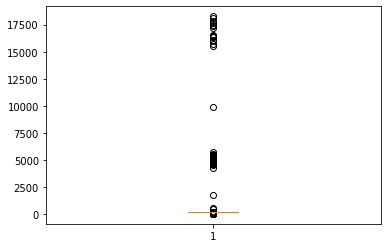

In [32]:
plt.boxplot(sum_table_clean['patientheight'])
plt.show()

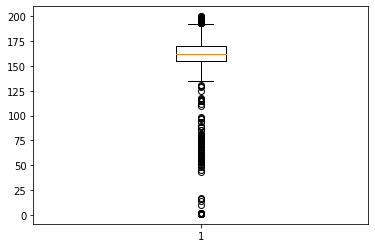

In [33]:
# where height is more than 300, or under 100, update value to '1'
sum_table_clean['patientheight'] = sum_table_clean['patientheight'].apply(lambda x: x if x < 300 else 1)
#sum_table_clean['patientheight'] = sum_table_clean['patientheight'].apply(lambda x: x if x > 100 else 1)
plt.boxplot(sum_table_clean['patientheight'])
plt.show()

count    25064.000000
mean       146.605724
std         51.131713
min          1.000000
25%        155.000000
50%        162.000000
75%        170.000000
max        200.000000
Name: patientheight, dtype: float64


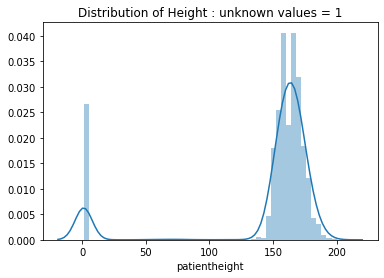

In [34]:
print(sum_table_clean['patientheight'].describe())
#sum_table_clean['patientheight'].hist()
sns.distplot(sum_table_clean['patientheight'])
plt.title('Distribution of Height : unknown values = 1')
plt.show()

In [35]:
sum_table_clean.columns

Index(['row_id', 'studyidk', 'age', 'gender', 'patientweight', 'patientheight',
       'findingcode', 'findingcodetext', 'conclusion', 'reasonforstudy',
       'studylocation', 'modality', 'equipment'],
      dtype='object')

## Study location

Unsure as to what this field intends to indicate.
98% of fields have been left blank.


In [36]:
print('Number of unique locations in database')
print(sum_table_clean['studylocation'].nunique())

print('Percentage of field left blank')
print(sum_table_clean['studylocation'][sum_table_clean['studylocation'] == ''].count()/number_of_rows)

sum_table_clean['studylocation'].value_counts()

Number of unique locations in database
42
Percentage of field left blank
0.9890280880944782


                                                                    24789
Cardiologia                                                           123
Medicina interna                                                       31
Cardiología                                                            17
Neumologia                                                             10
Hematologia                                                            10
NEFROLOGIA                                                              9
Neurologia                                                              8
CONSULTA CARDIOLOGIA                                                    7
Cardiolgia                                                              6
Cirugia Cardiaca                                                        5
HEMATOLOGÍA                                                             4
CIR CARDIACA                                                            4
REUMATOLOGIA                          

## Machine

There are 34 unqiue machines listed in the database.  

Questions:
- should I rename the blank ones as 'unknown'
- why are there machines with less than 20 or 30 records associated with them?  Are these mistakes/duplicates? 
- does machine type give any indication of the time period when the scan was taken, or the location?

In [37]:
print('Number of unique machine types in database')
print(sum_table_clean['equipment'].nunique())
sum_table_clean['equipment'].value_counts()

Number of unique machine types in database
34


AFFINITI_1          3383
ECOEPIQ2            3094
EPIQ7-1             2776
ECOIE33             2716
AFFINITI_2          2593
ECOCX50             2171
VIVID7-009324       2171
VIVID7-011509       1955
ECOCX50_2           1877
ECOEPIQ1             874
HD11_1_AE            517
                     322
PHILIPSHD15          111
VIVID7-CRODRIGO      111
QSTATION1             83
VIEWER_STORE_SCU      63
Vivide                47
37001403CARUS003      40
37001403CARUS006      32
ECOTOSHIBA            22
37001403CARUS002      22
VIVID7-BEJAR          15
ENVISOR               13
37001403CARUS005      10
HD11                  10
EPIQ 7-1               8
37001403CARUS001       7
VIVIDS70-000030        6
PORTATIL-UCIC          4
VT8-435431WX2          3
INTURISPRO_SCP         3
AFFINITI               2
37001403CARUS004       2
37001403CARARC01       1
Name: equipment, dtype: int64

## Create Features

### BMI

In [38]:
# Create BMI feature
#https://www.cdc.gov/nccdphp/dnpao/growthcharts/training/bmiage/page5_1.html
# [weight (kg) / height (cm) / height (cm)] x 10,000
def calc_bmi(weight_kg, height_cm):
    return ((weight_kg/height_cm/height_cm)*10000)

In [39]:
# Create BMI Columns
sum_table_clean['BMI'] = sum_table_clean.apply(lambda x: calc_bmi(x.patientweight, x.patientheight), axis=1)

In [40]:
# where BMI is more than 45, update value to '1'
sum_table_clean['BMI'] = sum_table_clean['BMI'].apply(lambda x: x if x < 45 else 1)
# where BMI is less than 15, update value to '1'
sum_table_clean['BMI'] = sum_table_clean['BMI'].apply(lambda x: x if x > 15 else 1)

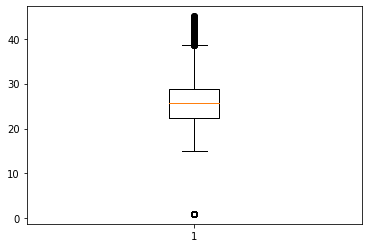

In [41]:
plt.boxplot(sum_table_clean['BMI'])
plt.show()

count    25064.000000
mean        23.770520
std          9.234910
min          1.000000
25%         22.405877
50%         25.677297
75%         28.906250
max         44.997166
Name: BMI, dtype: float64


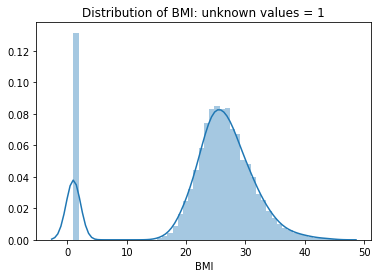

In [42]:
print(sum_table_clean['BMI'].describe())
#sum_table_clean['BMI'].hist()
sns.distplot(sum_table_clean['BMI'])
plt.title('Distribution of BMI: unknown values = 1')
plt.show()

## Finding Codes

In [43]:
print()

In [44]:
#codes for each of the pathologies
pathologies_of_interest = {'LV-0068', 'LV-0144', 'LV-0069', 'LV-0070', 'LV-0065', 'LV-0062'
                    ,'LV-0061', 'LV-0080','LV-0077','LV-0078'
                    , 'LV-0061', 'LA-0016', 'LA-0013', 'SU-0032'}

# Pathology dictonary
pathdict = {"LV-0062": "HC_F"
            ,"SU-0032": "Norm"
            ,"LV-0078": "RLVEF_F"
            ,"LV-0077": "RLVEF_F"
            ,"LV-0061": "RLVEF_F"
            ,"LV-0080": "RLVEF_T"
            ,"LV-0068": "HC_T"
            ,"LA-0016": "DLA_T"
            ,"LV-0065": "HC_F"
            ,"LV-0144": "HC_T"
            ,"LV-0070": "HC_C"
            ,"LA-0013": "DLA_F"
            ,"LV-0069": "HC_C"
           }

# Pathology codes
HC_T_codes = {'LV-0144', 'LV-0068'}
HC_F_codes = {'LV-0062', 'LV-0065', 'LV-0061'}
HC_C_codes = {'LV-0069', 'LV-0070'}

RLVEF_T_codes = {'LV-0080'}
RLVEF_F_codes = {'LV-0061', 'LV-0077', 'LV-0078'}

DLA_T_codes = {'LA-0016'}
DLA_F_codes = {'LA-0013'}

Norm_codes = {'SU-0032'}

In [45]:
def create_pathology_column(study_table, path_codes, path_name):
    #puts the code of interest in a new column
    study_table[path_name] = study_table.findingcode.apply(lambda x: intersection(x, path_codes)) 
    #replace the codes with 0 or 1 (NOTE: could return higher than 1 error?  needs to be handled)
    study_table[path_name] = study_table[path_name].apply(lambda x : len(x))
    
    #Convert the code from a list to a string
    #study_table[path_name] = study_table[path_name].apply(lambda x : ''.join(x))
    # replace the codes with the pathology names
    #study_table = study_table.replace({path_name: pathdict})
    return study_table

In [46]:
def intersection(lst1, lst2): 
#https://www.geeksforgeeks.org/python-intersection-of-multiple-lists/      
    return [item for item in lst1 if item in lst2] 

In [47]:
# turn the findingcode column into a list
sum_table_clean.findingcode = sum_table_clean.findingcode.apply(lambda x: x.split(","))

In [48]:
sum_table_clean.head(1)

,row_id,studyidk,age,gender,patientweight,patientheight,findingcode,findingcodetext,conclusion,reasonforstudy,studylocation,modality,equipment,BMI
0,1,118640,77,M,77.0,162.0,"[LV-0062, LV-0067, LV-0078, LV-0088, RV-00...",Ventrículo izquierdo de dimensiones normales. ...,RS. Buena calidad. ....- VI de tamańo y FEVI n...,SVAo. BAV 2ş,,US,EPIQ7-1,29.34004


In [49]:
# Count instances 
db_finding_codes = sum_table_clean[['studyidk','findingcode']].copy()
temp = db_finding_codes.apply(lambda x: pd.Series(x['findingcode']),axis=1).stack().reset_index(level=1, drop=True)
temp.name = 'finding_code_del'
db_finding_codes = db_finding_codes.drop('findingcode', axis=1).join(temp)
db_finding_codes = db_finding_codes.reset_index(drop=True)
db_finding_codes.head()

,studyidk,finding_code_del
0,118640,LV-0062
1,118640,LV-0067
2,118640,LV-0078
3,118640,LV-0088
4,118640,RV-0028


In [50]:
# Count of the unique number of finding codes present in the DB
unique_finding_codes = db_finding_codes['finding_code_del'].nunique()
print('number of unique finding codes in the database')
print(unique_finding_codes)

number of unique finding codes in the database
618


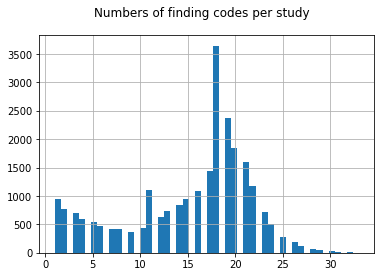

In [51]:
# Quick histogram of the number of finding codes per study in the database
axes = db_finding_codes['studyidk'].value_counts().hist(bins=50)
plt.suptitle("Numbers of finding codes per study")
plt.show()

In [52]:
# adding pathology column
sum_table_clean = create_pathology_column(sum_table_clean, HC_T_codes, "HC_T")
sum_table_clean = create_pathology_column(sum_table_clean, HC_F_codes, "HC_F")
sum_table_clean = create_pathology_column(sum_table_clean, HC_C_codes, "HC_C")
sum_table_clean = create_pathology_column(sum_table_clean, RLVEF_T_codes, "RLVEF_T")
sum_table_clean = create_pathology_column(sum_table_clean, RLVEF_F_codes, "RLVEF_F")
sum_table_clean = create_pathology_column(sum_table_clean, DLA_T_codes, "DLA_T")
sum_table_clean = create_pathology_column(sum_table_clean, DLA_F_codes, "DLA_F")
sum_table_clean = create_pathology_column(sum_table_clean, Norm_codes, "Norm")

In [53]:
sum_table_clean.head()

,row_id,studyidk,age,gender,patientweight,patientheight,findingcode,findingcodetext,conclusion,reasonforstudy,...,equipment,BMI,HC_T,HC_F,HC_C,RLVEF_T,RLVEF_F,DLA_T,DLA_F,Norm
0,1,118640,77,M,77.0,162.0,"[LV-0062, LV-0067, LV-0078, LV-0088, RV-00...",Ventrículo izquierdo de dimensiones normales. ...,RS. Buena calidad. ....- VI de tamańo y FEVI n...,SVAo. BAV 2ş,...,EPIQ7-1,29.340040,0,1,0,0,0,0,0,0
1,2,115777,82,F,45.0,157.0,"[LV-0063, LV-0069, LV-0078, LV-0086, LV-00...",Cavidad del ventrículo izquierdo reducida. Com...,Estudio de buena calidad. Realizado en RS a 70...,Angina inestable,...,ECOEPIQ2,18.256319,0,0,0,0,0,0,0,0
2,3,49414,67,M,69.0,168.0,"[LV-0077, MV-0108, AV-0087]",La fracción de eyección del ventrículo izquier...,Seguimiento de P. con C. valvular e Isquemica....,Seguimiento de P. con C. valvular e Isquemica,...,ECOIE33,24.447279,0,0,0,0,1,0,0,0
3,4,79460,70,M,68.0,168.0,"[LV-0078, LV-0145, MV-0056, MV-0099, MV-01...",La función sistólica ventricular izquierda es ...,Seguimiento de P. con C. isquemica cronica (...,Seguimiento de P. con C. isquemica cronica +...,...,AFFINITI_1,24.092971,0,0,0,0,1,0,0,0
4,5,118806,72,M,63.0,167.0,"[LV-0062, LV-0067, RV-0028, RV-0033, RV-00...",Ventrículo izquierdo de dimensiones normales. ...,Estudio realizado en FA 80-90 . Mala ventana ...,,...,AFFINITI_2,22.589551,0,1,0,0,0,0,0,0


In [55]:
sum_table_clean.to_csv('clean_summary_table.csv', index=False)

## Histograms: Pathologies by Demographics

In [ ]:
sum_table_clean['HC_T'].sum()

In [ ]:
# Create a table of relevant findingcodes/pathologies

columns = ["Findingcode diagnosing disease",
           "Findingcode compatible with disease", 
           "Findingcode normal for this pathology"]
rows = ["Hypertrophic Cardiomyopathy",
        "Reduced Left Ventricle Ejection Fraction",
       "Dilated Left Atria",
       "Normal study"]
data=[[sum_table_clean['HC_T'].sum(), sum_table_clean['HC_C'].sum(), sum_table_clean['HC_F'].sum()],
     [sum_table_clean['RLVEF_T'].sum(), " ", sum_table_clean['RLVEF_F'].sum()],
     [sum_table_clean['DLA_T'].sum(), " ", sum_table_clean['DLA_F'].sum()],
     [sum_table_clean['Norm'].sum(), " ", " "]]

ResultsTable = pd.DataFrame(index=rows, columns=columns, data=data)

ResultsTable


## Pathologies present by age, weight, height and BMI

In [ ]:
HC_T_Table = sum_table_clean[sum_table_clean['HC_T'] == 1]
RLVEF_T_Table = sum_table_clean[sum_table_clean['RLVEF_T'] == 1]
DLA_T_Table = sum_table_clean[sum_table_clean['DLA_T'] == 1]

# Age, weight, hieght, and BMI for HC_T
plt.figure(figsize=(18, 12))

plt.subplot(3, 4, 1)
HC_T_Table.age.hist()
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by Age)')
plt.xlabel('age (years)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 5)
RLVEF_T_Table.age.hist(color='red')
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by Age)')
plt.xlabel('age (years)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 9)
DLA_T_Table.age.hist(color='green')
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by Age)')
plt.xlabel('age (years)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 2)
HC_T_Table.patientweight.hist()
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by Weight)')
plt.xlabel('Weight (kg)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 6)
RLVEF_T_Table.patientweight.hist(color='red')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by Weight)')
plt.xlabel('Weight (kg)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 10)
DLA_T_Table.patientweight.hist(color='green')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by Weight)')
plt.xlabel('Weight (kg)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 3)
HC_T_Table.patientheight.hist()
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by Height)')
plt.xlabel('Height (cm)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 7)
RLVEF_T_Table.patientheight.hist(color='red')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by Height)')
plt.xlabel('Height (cm)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 11)
DLA_T_Table.patientheight.hist(color='green')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by Height)')
plt.xlabel('Height (cm)')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 4)
HC_T_Table.BMI.hist()
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Hypertropic Cardiomypathy (by BMI)')
plt.xlabel('BMI')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 8)
RLVEF_T_Table.BMI.hist(color='red')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Left Ventricle Ejection Fraction (by BMI)')
plt.xlabel('BMI')
plt.ylabel('Number of cases')

plt.subplot(3, 4, 12)
DLA_T_Table.BMI.hist(color='green')
#plt.yticks(range(0, 4500, 500), fontsize=14) 
plt.grid(b=None)
plt.title('Dilated Left Ventricle (by BMI)')
plt.xlabel('BMI')
plt.ylabel('Number of cases')

plt.tight_layout()
plt.show()

# Import information on instances and views

Import csv created by Yoni on breakdown of instances and views

In [ ]:
tb_instances_views = pd.read_csv('../data/02_intermediate/frames_with_views.csv')
tb_instances_views.head()

In [ ]:
print(tb_instances_views.shape)
print(tb_instances_views.dtypes)

In [ ]:
sum_table_clean['studyidk'] = sum_table_clean.studyidk.astype(np.float64)
print(sum_table_clean.shape)
print(sum_table_clean.dtypes)

## Join tables

In [ ]:
tb_instances_views_studies = pd.merge(tb_instances_views, sum_table_clean, on='studyidk', how='left')
print(tb_instances_views_studies.shape)

In [ ]:
tb_instances_views_studies.head()

In [ ]:
tb_instances_views_studies.columns

# EDA on views

In [ ]:
tb_is_plax = tb_instances_views_studies[tb_instances_views_studies['is_plax'] == True]
print('Number of instances with parasternal axis view: {}'.format(tb_is_plax.shape[0]))
print('Number of unique studies with parasternal axis view: {}'.format(tb_is_plax.studyidk.nunique()))

tb_is_ac4 = tb_instances_views_studies[tb_instances_views_studies['is_a4c'] == True]
print('Number of instances with apical four chambers view: {}'.format(tb_is_ac4.shape[0]))
print('Number of unique studies with apical four chambers view: {}'.format(tb_is_ac4.studyidk.nunique()))

tb_is_ac2 = tb_instances_views_studies[tb_instances_views_studies['is_a2c'] == True]
print('Number of instances with apical two chambers view: {}'.format(tb_is_ac2.shape[0]))
print('Number of unique studies with apical two chambers view: {}'.format(tb_is_ac2.studyidk.nunique()))

In [ ]:
data = {'view_name': ['PLAX', 'AC4', 'AC2'],
        'Numbers_of_studies': [tb_is_plax.studyidk.nunique(), tb_is_ac4.studyidk.nunique(), tb_is_ac2.studyidk.nunique()],
        'Numbers_of_instances': [tb_is_plax.shape[0], tb_is_ac4.shape[0],tb_is_ac2.shape[0]]}

study_view_numbers = pd.DataFrame(data, columns=['view_name', 'Numbers_of_studies', 'Numbers_of_instances'])
study_view_numbers.head()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1,2,1)
sns.barplot(x="view_name", y="Numbers_of_studies", data =study_view_numbers).set_title('Numbers of unique studies with examples of each view')
plt.ylim(5000, 40000)

plt.subplot(1,2,2)
sns.barplot(x="view_name", y="Numbers_of_instances", data =study_view_numbers).set_title('Numbers of instances with examples of each view')
plt.ylim(5000, 40000)
plt.show()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1,3,1)
sns.barplot(x="gender", y="studyidk", data=tb_is_plax).set_title('Parasternal Axis View: Gender by instance')
plt.ylim(2000, 100000)

plt.subplot(1,3,2)
sns.barplot(x="gender", y="studyidk", data=tb_is_ac4).set_title('Apical Four Chambers View: Gender by instance')
plt.ylim(2000, 100000)

plt.subplot(1,3,3)
sns.barplot(x="gender", y="studyidk", data=tb_is_ac2).set_title('Apical Two Chambers View: Gender by instance')
plt.ylim(2000, 100000)
plt.show()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1,3,1)
plt.hist(tb_is_plax.age)
plt.title('Parasternal Axis View: Age by instance')
plt.ylim(0, 12000)

plt.subplot(1,3,2)
plt.hist(tb_is_ac4.age)
plt.title('Apical Four Chambers View: Age by instance')
plt.ylim(0, 12000)

plt.subplot(1,3,3)
plt.hist(tb_is_ac2.age)
plt.title('Apical Two Chambers View: Age by instance')
plt.ylim(0, 12000)
plt.show()

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1,3,1)
plt.hist(tb_is_plax.BMI)
plt.title('Parasternal Axis View: BMI by instance')
plt.ylim(0, 15200)

plt.subplot(1,3,2)
plt.hist(tb_is_ac4.BMI)
plt.title('Apical Four Chambers View: BMI by instance')
plt.ylim(0, 15200)

plt.subplot(1,3,3)
plt.hist(tb_is_ac2.BMI)
plt.title('Apical Two Chambers View: BMI by instance')
plt.ylim(0, 15200)
plt.show()